## Conditional image generation

we will train Conditional Variational Autoencoders in this notebook and learn how to condition them to certain attributes like hair, beard, gender, skin tone.

<table>
    <td>
      <img src="https://drive.google.com/uc?id=1gt3VRvxLig-NYWrtq6kpg2cLmWxc3glc" width="700"/>
    </td>
  <tr>
    <td style="vertical-align: top; padding-left: 20px;">
      <p><b>VAE Architecture:</b></p>
      <p>This diagram visualizes the flow of the Variational Autoencoder:</p>
      <ul>
        <li><b>Encoder</b>: Compresses the input image into a latent space.</li>
        <li><b>Latent Sampling</b>: Applies the reparameterization trick.</li>
        <li><b>Decoder</b>: Reconstructs the image from the latent vector.</li>
        <li><b>Conditional Inputs</b>: Attributes like gender, hair, and beard modify the output.</li>
      </ul>
      <p>Observe how the attributes influence the generated image!</p>
    </td>
  </tr>
</table>


<div>
<table>
    <td style="vertical-align: top;">
      <img src="https://drive.google.com/uc?id=14IyJzoXVIcetfis8dfw0utwbi6lf-975" width="700">
    </td>
  <tr>
    <td style="vertical-align: top; padding-left: 20px;">
      <p><b>Reparameterization Trick:</b></p>
      <p>This diagram illustrates the reparameterization trick, a crucial component of Variational Autoencoders (VAEs):</p>
      <ul>
        <li><b>Encoder</b>: Maps the input image into two vectors — the mean (<code>μ</code>) and log-variance (<code>log(σ²)</code>) of the latent distribution.</li>
        <li><b>Sampling</b>: Instead of sampling directly from the distribution (which breaks backpropagation), the trick introduces a random noise <code>ε</code> sampled from a standard normal distribution.</li>
        <li><b>Latent Vector (z)</b>: Computed as <code>z = μ + σ * ε</code>, allowing gradients to flow through <code>μ</code> and <code>σ</code> during training.</li>
        <li><b>Decoder</b>: Reconstructs the image from the latent vector <code>z</code>.</li>
      </ul>
      <p>This technique makes the sampling step differentiable, enabling end-to-end learning of the VAE.</p>
    </td>
  </tr>
</table>
</div>

![Hair growth GIF](https://drive.google.com/uc?id=12-sOaXhkCLBod7Y9f1fR-FEclSTPE-S6)


## Requirements

In [ ]:
import torch
import torchvision
from torchvision import transforms as T
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import glob
import os, re, shutil
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import Image as IPImage
import torch.nn.functional as F

In [ ]:
from IPython.display import clear_output
!pip install torchinfo
clear_output()
from torchinfo import summary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Helper functions

In [ ]:
def latent_interpolation_gif(model, steps, output_path, device, attrs, latent_dim=16, scale_size=512, framerate=10):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    z_start = torch.randn(1, latent_dim).to(device)
    z_end = torch.randn(1, latent_dim).to(device)

    temp_img_dir = os.path.join(os.path.dirname(output_path), "frames")
    os.makedirs(temp_img_dir, exist_ok=True)

    for step in range(steps):
        alpha = step / (steps - 1)
        z_interp = (1 - alpha) * z_start + alpha * z_end

        #decode with fixed attributes
        generated= model.decoder(z_interp, attrs)

        #convert to numpy image
        generated_img = generated.cpu().detach().numpy()[0]  # (3, 128, 128)
        img = np.moveaxis(generated_img, 0, -1)  # CHW to HWC
        img = (img * 255).astype(np.uint8)

        frame_path = os.path.join(temp_img_dir, f"frame_{step:03d}.png")
        Image.fromarray(img).save(frame_path)
        print(f'temp_img_dir {temp_img_dir}')
        print(f"saved {frame_path}")

    time.sleep(2)
    gif_command = f'ffmpeg -y -framerate {framerate} -i {temp_img_dir}/frame_%03d.png -vf "scale={scale_size}:-1" {output_path}'
    os.system(gif_command)

    print(f"GIF saved to {output_path}")

In [ ]:
def show_original_vs_reconstructed(model, dataloader, device, num_images=10):
    model.eval()

    images, attr = next(iter(dataloader))
    images = images[:num_images].to(device)
    attr = attr[:num_images].to(device)

    with torch.no_grad():
        reconstructions, _, _ = model(images, attr)
    reconstructions = reconstructions.cpu()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        axes[0, i].imshow(images[i].cpu().squeeze().permute(1,2,0).numpy())
        axes[0, i].axis('off')

        axes[1, i].imshow(reconstructions[i].squeeze().permute(1,2,0).numpy())
        axes[1, i].axis('off')

    axes[0, 0].set_title('original images', fontsize=12)
    axes[1, 0].set_title('reconstructed images', fontsize=12)
    plt.show()

def show_image(image):
    plt.imshow(image.cpu().detach().permute(1,2,0).numpy())
    plt.axis('off')

def showImage(x, model, latent_dim, device):
    attrs = torch.Tensor(x)
    img = model.decoder(torch.randn(1,latent_dim).to(device), attrs.to(device))
    img = img[0].cpu().detach().permute(1,2,0).numpy()
    return img

## Data

In [ ]:
os.environ['KAGGLEHUB_CACHE'] = '/content/data'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.33G/1.33G [01:01<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/jessicali9530/celeba-dataset/versions/2


In [ ]:
path = '/content/data/datasets/jessicali9530/celeba-dataset/versions/2'

In [ ]:
root = path+'/img_align_celeba/img_align_celeba'
attr_file = '/content/data/datasets/jessicali9530/celeba-dataset/versions/2/list_attr_celeba.csv'
root

'/content/data/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba'

### seeing the attributes we gonna do the conditioning

In [ ]:
import pandas as pd

df = pd.read_csv('/content/data/datasets/jessicali9530/celeba-dataset/versions/2/list_attr_celeba.csv')
df

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0       000001.jpg                -1                1           1   
1       000002.jpg                -1               -1          -1   
2       000003.jpg                -1               -1          -1   
3       000004.jpg                -1               -1           1   
4       000005.jpg                -1                1           1   
...            ...               ...              ...         ...   
202594  202595.jpg                -1               -1           1   
202595  202596.jpg                -1               -1          -1   
202596  202597.jpg                -1               -1          -1   
202597  202598.jpg                -1                1           1   
202598  202599.jpg                -1                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                    -1    -1     -1        -1        -1          -1  ...   
1                     1    -1     -1        -1         1          -1  ...   
2                    -1    -1     -1         1        -1          -1  ...   
3                    -1    -1     -1        -1        -1          -1  ...   
4                    -1    -1     -1         1        -1          -1  ...   
...                 ...   ...    ...       ...       ...         ...  ...   
202594               -1    -1     -1         1        -1          -1  ...   
202595               -1    -1      1         1        -1          -1  ...   
202596               -1    -1     -1        -1        -1           1  ...   
202597               -1    -1     -1         1        -1           1  ...   
202598               -1    -1     -1        -1        -1          -1  ...   

        Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
0              -1        1              1         -1                 1   
1              -1        1             -1         -1                -1   
2              -1       -1             -1          1                -1   
3              -1       -1              1         -1                 1   
4              -1       -1             -1         -1                -1   
...           ...      ...            ...        ...               ...   
202594         -1       -1             -1         -1                -1   
202595         -1        1              1         -1                -1   
202596         -1        1             -1         -1                -1   
202597         -1        1             -1          1                 1   
202598         -1       -1             -1          1                -1   

        Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
0                -1                 1                -1               -1   
1                -1                -1                -1               -1   
2                -1                -1                -1               -1   
3                -1                 1                 1               -1   
4                -1                 1                -1               -1   
...             ...               ...               ...              ...   
202594           -1                 1                -1               -1   
202595           -1                -1                -1               -1   
202596           -1                -1                -1               -1   
202597           -1                 1                -1               -1   
202598           -1                 1                -1               -1   

        Young  
0           1  
1           1  
2           1  
3           1  
4           1  
...       ...  
202594      1  
202595      1  
202596      1  
202597      1  
202598      1  

[202599 rows x 41 columns]

#### Extracting the attributes i am interested at

In [ ]:
def haircolor(x):
    if x["Blond_Hair"] == 1:
        return 0
    elif x["Brown_Hair"] == 1:
        return 1
    elif x["Black_Hair"] == 1:
        return 2
    else :
        return 3

df["Hair_Color"] = df.apply(haircolor,axis=1)

In [ ]:
df = df[["image_id","Hair_Color",'Pale_Skin',"Male","No_Beard"]]
df

image_id  Hair_Color  Pale_Skin  Male  No_Beard
0       000001.jpg           1         -1    -1         1
1       000002.jpg           1         -1    -1         1
2       000003.jpg           3         -1     1         1
3       000004.jpg           3         -1    -1         1
4       000005.jpg           3         -1    -1         1
...            ...         ...        ...   ...       ...
202594  202595.jpg           0         -1    -1         1
202595  202596.jpg           0          1     1         1
202596  202597.jpg           2         -1     1         1
202597  202598.jpg           2         -1    -1         1
202598  202599.jpg           0          1    -1         1

[202599 rows x 5 columns]

In [ ]:
"""
replacing -1 with 0 without affecting the the 1 values

"""
df.Pale_Skin = df.Pale_Skin.apply(lambda x: max(x,0))
df.Male = df.Male.apply(lambda x: max(x,0))
df.No_Beard = df.No_Beard.apply(lambda x: max(x,0))

<ipython-input-10-aa329b7d36ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Pale_Skin = df.Pale_Skin.apply(lambda x: max(x,0))
<ipython-input-10-aa329b7d36ba>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Male = df.Male.apply(lambda x: max(x,0))
<ipython-input-10-aa329b7d36ba>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [ ]:
df

image_id  Hair_Color  Pale_Skin  Male  No_Beard
0       000001.jpg           1          0     0         1
1       000002.jpg           1          0     0         1
2       000003.jpg           3          0     1         1
3       000004.jpg           3          0     0         1
4       000005.jpg           3          0     0         1
...            ...         ...        ...   ...       ...
202594  202595.jpg           0          0     0         1
202595  202596.jpg           0          1     1         1
202596  202597.jpg           2          0     1         1
202597  202598.jpg           2          0     0         1
202598  202599.jpg           0          1     0         1

[202599 rows x 5 columns]

In [ ]:
np_attr_matrix = df.to_numpy()[:, 1:]
np_attr = np_attr_matrix.astype(np.float32)
np_attr

array([[1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [3., 0., 1., 1.],
       ...,
       [2., 0., 1., 1.],
       [2., 0., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

### defining the transfroms and the cusom data class

In [ ]:
transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

In [ ]:
class CustomData(Dataset):
    def __init__(self, root, attr_matrix, transforms=None):
        self.root = root
        self.images_paths = sorted(glob.glob(os.path.join(root, '*.jpg')))
        self.transforms= transforms

        #cleaning the attributes
        self.attributes = torch.from_numpy(attr_matrix).to(torch.float32)

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img = Image.open(self.images_paths[idx])
        img = img.convert('RGB')
        if self.transforms: img = self.transforms(img)

        attr = self.attributes[idx]

        return img, attr

datasett = CustomData(root, np_attr, transforms)
len(datasett)

202599

## dataloaders and subsetting

Subset if you can't load all the images,

don't forget to pass subset_dataset variable inside the dataloader

In [ ]:
from torch.utils.data import Subset

indices = list(range(512))  # first 512 samples
subset_dataset = Subset(datasett, indices)

print(len(subset_dataset))

512


In [ ]:
image, attr = datasett[25]
image.shape, attr.shape

(torch.Size([3, 128, 128]), torch.Size([4]))

In [ ]:
print(attr)

tensor([1., 0., 0., 1.])


In [ ]:
print(image)

tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9804, 0.9961],
         [0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9882, 1.0000],
         [0.9922, 0.9922, 0.9922,  ..., 0.9804, 0.9922, 0.9961],
         ...,
         [0.6980, 0.6549, 0.5608,  ..., 0.3961, 0.3804, 0.3765],
         [0.5451, 0.5333, 0.6157,  ..., 0.4627, 0.4627, 0.4549],
         [0.6235, 0.7569, 0.8549,  ..., 0.4627, 0.4667, 0.4706]],

        [[0.9059, 0.9059, 0.9059,  ..., 0.9216, 0.9098, 0.9333],
         [0.9059, 0.9059, 0.9059,  ..., 0.9294, 0.9216, 0.9373],
         [0.9059, 0.9059, 0.9059,  ..., 0.9176, 0.9294, 0.9333],
         ...,
         [0.4392, 0.3922, 0.2980,  ..., 0.1451, 0.1333, 0.1294],
         [0.2824, 0.2706, 0.3412,  ..., 0.1961, 0.1961, 0.1961],
         [0.3569, 0.4902, 0.5804,  ..., 0.1922, 0.1922, 0.2000]],

        [[0.7608, 0.7608, 0.7608,  ..., 0.8353, 0.8588, 0.8706],
         [0.7608, 0.7608, 0.7608,  ..., 0.8431, 0.8706, 0.8745],
         [0.7608, 0.7608, 0.7608,  ..., 0.8353, 0.8745, 0.

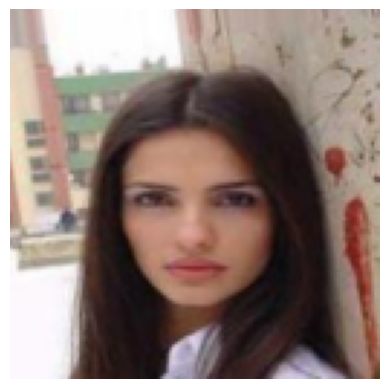

In [ ]:
show_image(image)

### dataloader definition

In [ ]:
print(num_worker:=os.cpu_count())

12


In [ ]:
train_dl = DataLoader(datasett, batch_size=512, num_workers=num_worker, persistent_workers=True)

# # uncomment this if you want to use the subset instead of the whole dataset
# train_dl = DataLoader(subset_dataset, batch_size=512, num_workers=num_worker, persistent_workers=True)

## VAE

In [ ]:
class Encoder(nn.Module):
    def __init__(self, img_channels, num_filters):
        super().__init__()
        # channels_in ,  channels_out, kernel_size, stride , padding,
        self.enc = nn.Sequential(
            nn.Conv2d(img_channels, num_filters, 3, 1, 1), # 128
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 64
            nn.BatchNorm2d(num_filters),

            nn.Conv2d(num_filters, 2*num_filters, 3, 1, 1), # 64
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 32
            nn.BatchNorm2d(2*num_filters),

            nn.Conv2d(2*num_filters, 4*num_filters, 3, 1, 1), # 32
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 16
            nn.BatchNorm2d(4*num_filters),

            nn.Conv2d(4*num_filters, 6*num_filters, 3, 1, 1), # 16
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), # 8
            nn.BatchNorm2d(6*num_filters),

            nn.Conv2d(6*num_filters, 8*num_filters, 3, 1, 1), # 8
            nn.BatchNorm2d(8*num_filters),
            nn.Tanh(),
        )

    def forward(self,x):
        return self.enc(x)

class Decoder(nn.Module):
    def __init__(self, attr_embed_dim, num_filters, latent_dim, output_channels):
        super().__init__()
        self.num_filters = num_filters
        self.attr_embed_dim = attr_embed_dim
        # embeddings
        self.hairEmbedding = nn.Embedding(4,attr_embed_dim) # one hot encoded, the hair have 4 values so it can be [0,0,1,0]
        self.beardEmbedding = nn.Embedding(2,attr_embed_dim)
        self.genderEmbedding = nn.Embedding(2,attr_embed_dim)
        self.paleSkinEmbedding = nn.Embedding(2,attr_embed_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim + 4 * attr_embed_dim, 8*num_filters * 8 * 8)
        #                                       ^ those 4 are the columns of the attributes
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8*num_filters, 6*num_filters, 2, stride=2),  # 16
            nn.LeakyReLU(),
            nn.BatchNorm2d(6*num_filters),

            nn.Conv2d(6*num_filters, 6*num_filters, 3, 1, 1),  # 16
            nn.LeakyReLU(),
            nn.BatchNorm2d(6*num_filters),


            nn.ConvTranspose2d(6*num_filters, 4*num_filters, 2, stride=2),  # 32
            nn.LeakyReLU(),
            nn.BatchNorm2d(4*num_filters),

            nn.Conv2d(4*num_filters, 4*num_filters, 3, 1, 1),  # 32
            nn.LeakyReLU(),
            nn.BatchNorm2d(4*num_filters),


            nn.ConvTranspose2d(4*num_filters, 2*num_filters, 2, stride=2),  # 64
            nn.LeakyReLU(),
            nn.BatchNorm2d(2*num_filters),

            nn.Conv2d(2*num_filters, 2*num_filters, 3, 1, 1),  # 64
            nn.LeakyReLU(),
            nn.BatchNorm2d(2*num_filters),


            nn.ConvTranspose2d(2*num_filters, num_filters, 2, stride=2),  # 128
            nn.LeakyReLU(),
            nn.BatchNorm2d(num_filters),

            nn.Conv2d(num_filters, num_filters, 3, 1, 1),  # 128
            nn.LeakyReLU(),
            nn.BatchNorm2d(num_filters),

            nn.Conv2d(num_filters, output_channels, 1, 1),  # 128, 128, 3
            nn.Sigmoid()
        )

    def forward(self, z, attr):
        hair = self.hairEmbedding(attr[:, 0].long()) # 0 is the index of the column of this attribute!
        beard = self.beardEmbedding(attr[:, 1].long())
        gender = self.genderEmbedding(attr[:, 2].long())
        paleSkin = self.paleSkinEmbedding(attr[:, 3].long())

        """
        Concating the embeddings and the encoded image
        """
        z = torch.cat([z,hair,beard,gender,paleSkin],dim=1)
        h_dec = self.fc_decode(z).view(-1, 8 * self.num_filters, 8, 8) #unflatten
        return self.decoder(h_dec)

class ConditionalVAE(nn.Module):
    def __init__(self, img_channels, attr_embed_dim, num_filters, latent_dim, output_channels):
        super().__init__()
        self.num_filters = num_filters

        # Encoder
        self.encoder = Encoder(img_channels, num_filters)
        self.decoder = Decoder(attr_embed_dim, num_filters, latent_dim, output_channels)

        self.fc_mu = nn.Linear(8*num_filters * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(8*num_filters * 8 * 8, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, img, attr):
        # Encode
        h = self.encoder(img)
        h_flat = h.view(h.size(0), -1)

        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)

        z = self.reparameterize(mu, logvar) #sampling

        # Decode with attributes
        generated = self.decoder(z, attr)

        return generated, mu, logvar

In [ ]:
latent_dim = 16

In [ ]:
model = ConditionalVAE(img_channels=3, attr_embed_dim=10, num_filters=16, latent_dim=latent_dim, output_channels=3).to(device)

In [ ]:
img = torch.randn(2, 3, 128, 128)
attr = torch.tensor([
    [1, 0, 1, 0],  # hair, beard, gender, pale_skin
    [2, 1, 0, 1]
])
output, mu, logvar = model(img.to(device), attr.to(device))
print(output.shape)

torch.Size([2, 3, 128, 128])


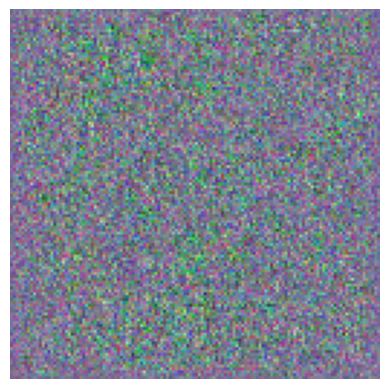

In [ ]:
show_image(output[0])

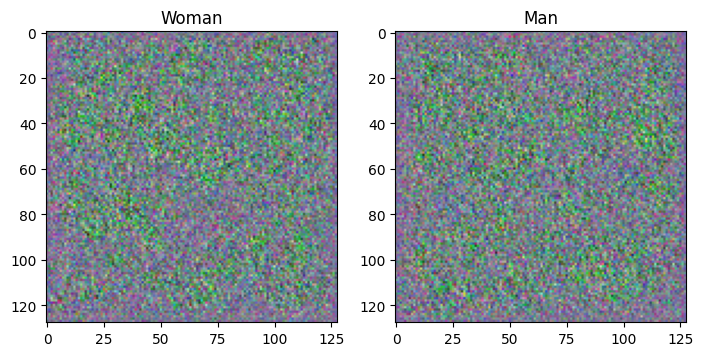

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,0,1]], model, latent_dim, device))
axarr[0].set_title("Woman")
axarr[1].imshow(showImage([[2,0,1,0]], model, latent_dim, device))
axarr[1].set_title("Man")

f.subplots_adjust(hspace=0.3,left=2,right=3)

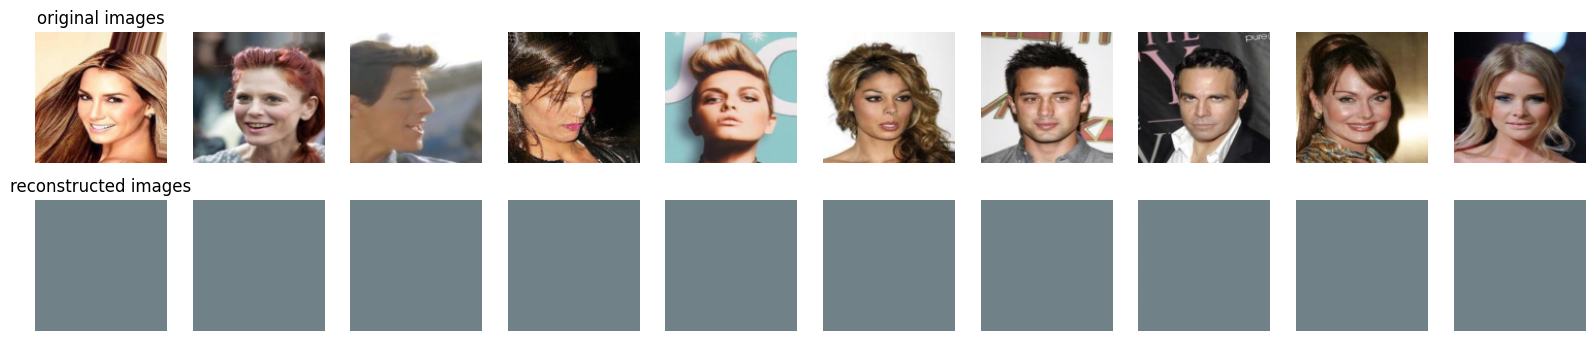

In [ ]:
show_original_vs_reconstructed(model, train_dl, device, num_images=10)

In [ ]:
summary(model.cpu(), input_data=(img, attr))

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalVAE                           [2, 3, 128, 128]          --
├─Encoder: 1-1                           [2, 128, 8, 8]            --
│    └─Sequential: 2-1                   [2, 128, 8, 8]            --
│    │    └─Conv2d: 3-1                  [2, 16, 128, 128]         448
│    │    └─LeakyReLU: 3-2               [2, 16, 128, 128]         --
│    │    └─MaxPool2d: 3-3               [2, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-4             [2, 16, 64, 64]           32
│    │    └─Conv2d: 3-5                  [2, 32, 64, 64]           4,640
│    │    └─LeakyReLU: 3-6               [2, 32, 64, 64]           --
│    │    └─MaxPool2d: 3-7               [2, 32, 32, 32]           --
│    │    └─BatchNorm2d: 3-8             [2, 32, 32, 32]           64
│    │    └─Conv2d: 3-9                  [2, 64, 32, 32]           18,496
│    │    └─LeakyReLU: 3-10              [2, 64, 32, 32]           --
│    │ 

In [ ]:
model.to(device)
for p in model.parameters():
    print(p.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [ ]:
def loss_function(recon_x,x,mu,logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= x.shape[0] * 3 * 64 * 64
    recon_loss = F.mse_loss(recon_x,x)
    return recon_loss +  KLD

In [ ]:
epochs=1
learning_rate=0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = loss_function
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

In [ ]:
train_losses=[]
val_losses=[]

In [ ]:
def train_cycle(model, data, optimizer, loss_fn, gradient_clip):
    total_loss=0

    model.train()
    for features, attr in tqdm(data):
        features = features.to(device)
        attr = attr.to(device)

        #forward
        preds, mu, logvar = model(features, attr)
        loss = loss_fn(preds, features, mu, logvar)

        #backward
        optimizer.zero_grad()
        loss.backward()

        if gradient_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()

        total_loss += loss.item()

    #calculating losses
    avg_batch_loss = total_loss/len(data)

    return avg_batch_loss

In [ ]:
def train(model, train_dl, optimizer, loss_fn, scheduler, epochs, gradient_clip):

    for epoch in range(epochs):

        ##TRAINING
        train_loss = train_cycle(model, train_dl, optimizer, loss_fn, gradient_clip)
        if epoch % 1 == 0:
            show_original_vs_reconstructed(model, train_dl, device, num_images=2)
        scheduler.step()
        train_losses.append(train_loss)
        print()
        print(f'epoch {epoch+1}/{epochs}')
        print(f'training loss: {train_loss:.4f}')
        # print(f'learning rate {scheduler.get_last_lr:.6f}')

100%|██████████| 396/396 [01:17<00:00,  5.08it/s]


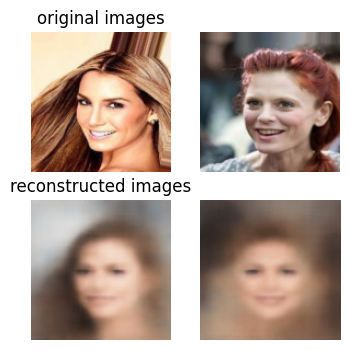


epoch 1/3
training loss: 0.0279


100%|██████████| 396/396 [01:19<00:00,  5.00it/s]


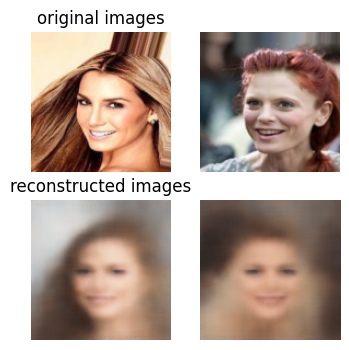


epoch 2/3
training loss: 0.0266


100%|██████████| 396/396 [01:19<00:00,  4.97it/s]


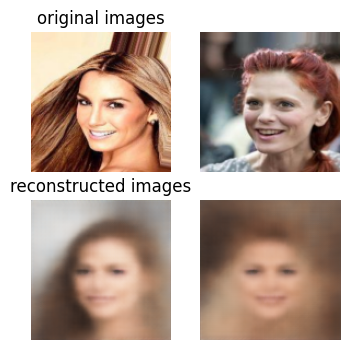


epoch 3/3
training loss: 0.0264


In [ ]:
train(model, train_dl, optimizer, loss_fn, scheduler, epochs, gradient_clip=False)

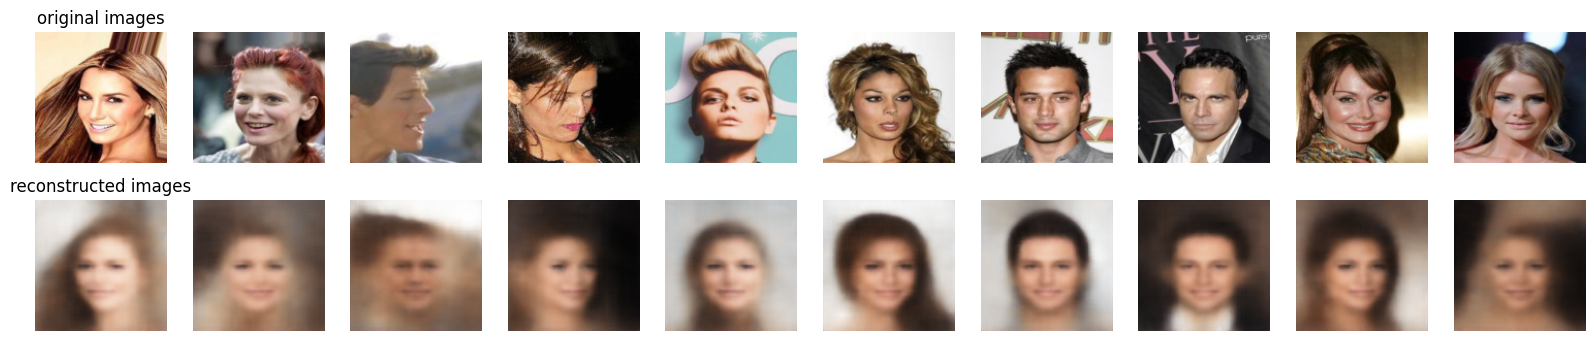

In [ ]:
show_original_vs_reconstructed(model, train_dl, device, num_images=10)

## Small latent results

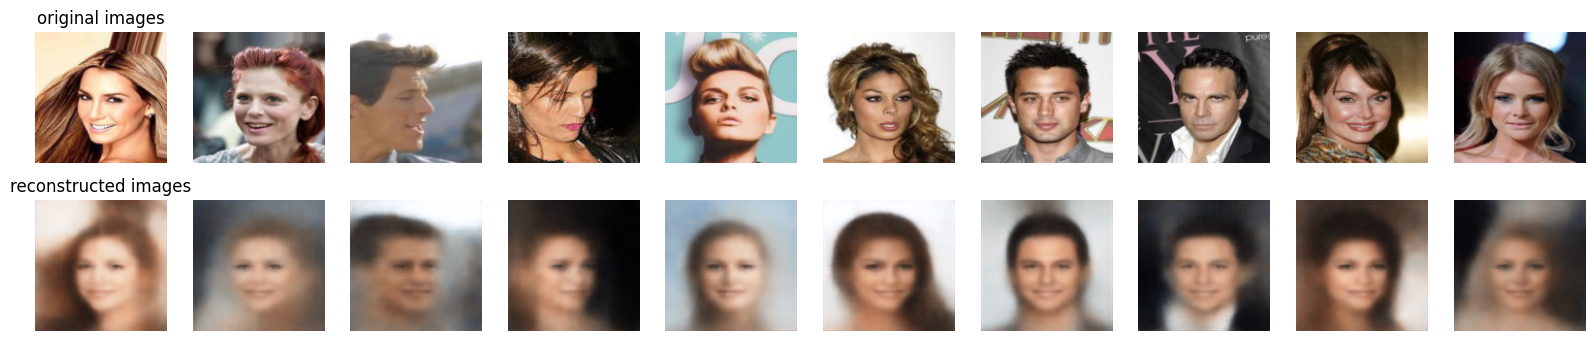

In [ ]:
show_original_vs_reconstructed(model, train_dl, device, num_images=10)

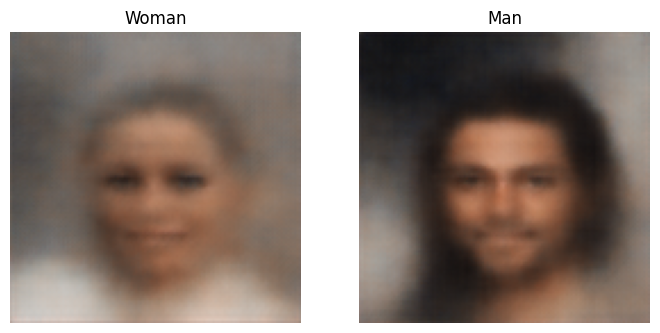

In [ ]:
latent_dim=16
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,0,1]], model, latent_dim, device))
axarr[0].set_title("Woman")
axarr[0].axis('off')
axarr[1].imshow(showImage([[2,0,1,0]], model, latent_dim, device))
axarr[1].set_title("Man")
axarr[1].axis('off')
f.subplots_adjust(hspace=0.3,left=2,right=3)

## Big latent results

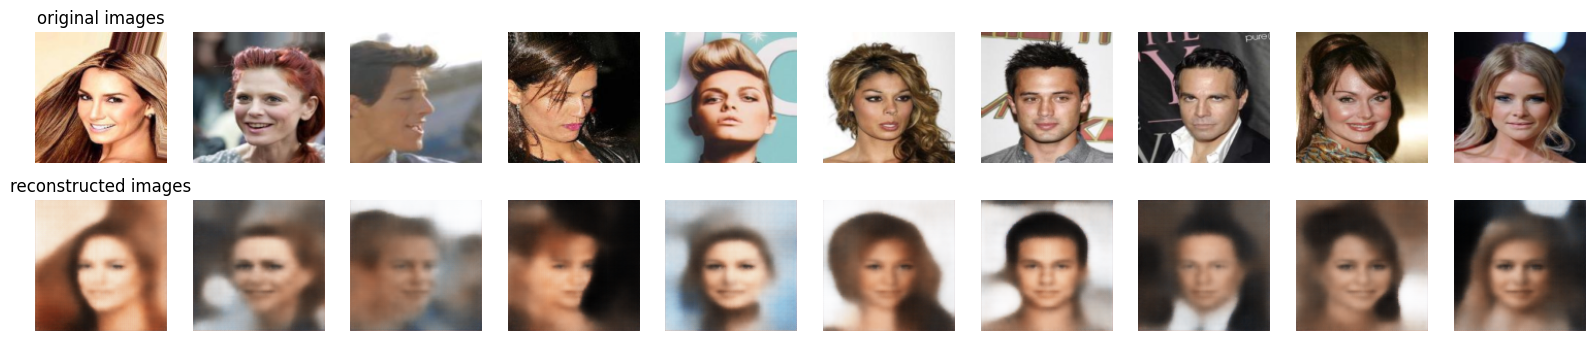

In [ ]:
show_original_vs_reconstructed(model, train_dl, device, num_images=10)

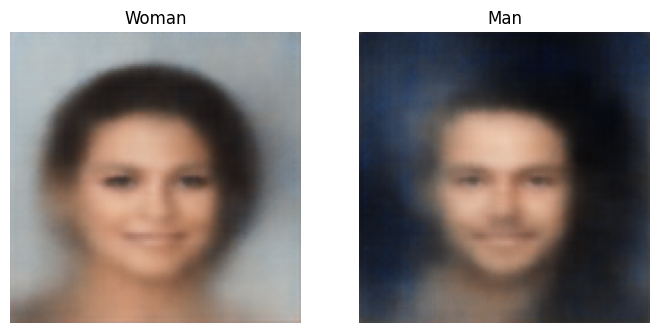

In [ ]:
latent_dim=16
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,0,1]], model, latent_dim, device))
axarr[0].set_title("Woman")
axarr[0].axis('off')
axarr[1].imshow(showImage([[2,0,1,0]], model, latent_dim, device))
axarr[1].set_title("Man")
axarr[1].axis('off')
f.subplots_adjust(hspace=0.3,left=2,right=3)

## Loading the model

In [ ]:
model = ConditionalVAE(img_channels=3, attr_embed_dim=10, num_filters=16, latent_dim=16, output_channels=3).to(device)

In [ ]:
!wget -O small_latent_CVAE.pth "https://drive.google.com/uc?id=1A6oiJs9cOXwWiWq97OLyzckz57-KbunN"

model.load_state_dict(torch.load('small_latent_CVAE.pth', map_location=device))

--2025-03-21 00:21:02--  https://drive.google.com/uc?id=1A6oiJs9cOXwWiWq97OLyzckz57-KbunN
Resolving drive.google.com (drive.google.com)... 142.251.10.139, 142.251.10.113, 142.251.10.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.10.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1A6oiJs9cOXwWiWq97OLyzckz57-KbunN [following]
--2025-03-21 00:21:03--  https://drive.usercontent.google.com/download?id=1A6oiJs9cOXwWiWq97OLyzckz57-KbunN
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.130.132, 2404:6800:4003:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.130.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4586194 (4.4M) [application/octet-stream]
Saving to: ‘small_latent_CVAE.pth’

small_latent_CVAE.p 100%[===================>]   4.37M  --.-KB/s    in 0.04s   

2025-03-21 00:21:05 (107

<All keys matched successfully>

## Let's make a vid and have fun!

In [ ]:
os.makedirs('/content/output/', exist_ok=True)

In [ ]:
attrs = torch.tensor([[
                        3, # values from 0 to 3 of hair attribute
                        1, # values from 0 to 1 of beardness attribute (0 no beard, 1 is beard)
                        1, # values from 0 to 1 of gender attribute (0 is female, 1 is male)
                        1  # values from 0 to 1 of skin tone attribute (0 is dark, 1 is white)
                       ]]).to(device)
latent_interpolation_gif(
    model=model,
    steps=50,
    output_path="/content/output/latent_interp.gif",
    device=device,
    attrs=attrs,
    latent_dim=16,
    scale_size=512,
    framerate=10
)
clear_output()

In [ ]:
IPImage('/content/output/latent_interp.gif')

Output hidden; open in https://colab.research.google.com to view.